# EfficientNetB0V2 with SMOTE for Imbalanced data with final dataset

# Import Libraries

In [12]:
from clearml import Task
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from keras.src.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight, compute_class_weight
import random
import shutil
from glob import glob
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
task = Task.init(project_name='Architecture Style Classification', task_name='Using weighted classes for imbalanced data')

ClearML Task: created new task id=822c32e6c35043c1bc14a6a8168200a8
2024-04-12 13:52:12,545 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/fb01ac3f8ec0442db15dd95b35c1dc10/experiments/822c32e6c35043c1bc14a6a8168200a8/output/log


# Data Extraction

In [23]:
dataset_path = "D:/University/ArchitectureStyles/archive/architectural-styles-dataset"
def get_image_paths_and_labels(directory_path):
    data = []
    for root, dirs, files in os.walk(directory_path):
        for label in dirs:
            label_path = os.path.join(root, label)
            for image_path in glob(os.path.join(label_path, "*")):  
                if os.path.isfile(image_path):
                    label_hierarchy = os.path.relpath(label_path, directory_path).split(os.path.sep)
                    label_string = ", ".join(label_hierarchy)
                    data.append((image_path, label_string))

    return data

In [24]:
images_with_labels = get_image_paths_and_labels(dataset_path)
data = pd.DataFrame(images_with_labels, columns=['image_name', 'label'])
data

,image_name,label
0,D:/University/ArchitectureStyles/archive/archi...,Achaemenid architecture
1,D:/University/ArchitectureStyles/archive/archi...,Achaemenid architecture
2,D:/University/ArchitectureStyles/archive/archi...,Achaemenid architecture
3,D:/University/ArchitectureStyles/archive/archi...,Achaemenid architecture
4,D:/University/ArchitectureStyles/archive/archi...,Achaemenid architecture
...,...,...
9725,D:/University/ArchitectureStyles/archive/archi...,Tudor Revival architecture
9726,D:/University/ArchitectureStyles/archive/archi...,Tudor Revival architecture
9727,D:/University/ArchitectureStyles/archive/archi...,Tudor Revival architecture
9728,D:/University/ArchitectureStyles/archive/archi...,Tudor Revival architecture


# Data Exploration

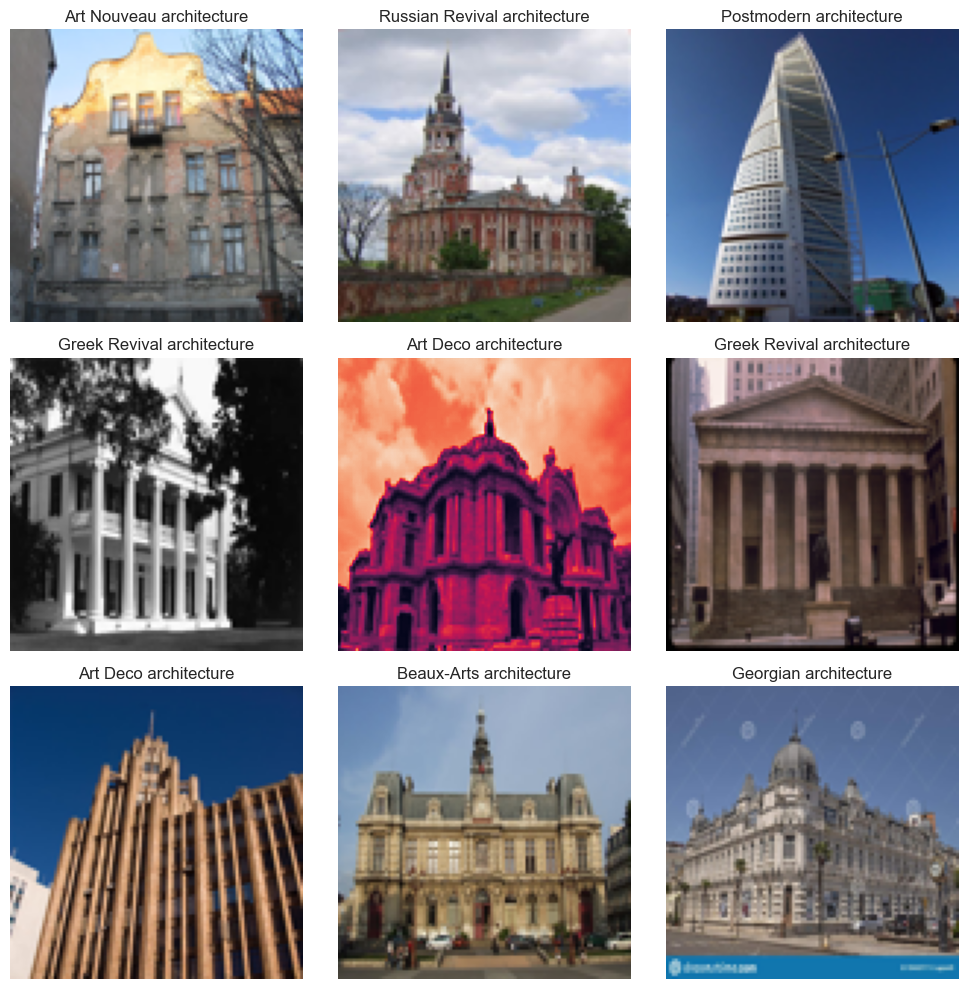

In [25]:
classes = [subfolder for subfolder in os.listdir(dataset_path) if
           os.path.isdir(os.path.join(dataset_path, subfolder))]
plt.figure(figsize=(10, 10))
data_to_show = data.sample(frac=1)[:9]

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    img = Image.open(data_to_show.iloc[i, 0])  # Opening the image
    img_resized = img.resize((100, 100))
    plt.imshow(img_resized)
    plt.title(data_to_show.iloc[i, 1])  # Convert one-hot encoded labels to class names
    plt.axis("off")
plt.tight_layout()
plt.show()

# Data Split

In [30]:
train_dataset, temp_dataset = train_test_split(data,
                                               stratify=data['label'],
                                               test_size=0.3,
                                               random_state=42)
test_dataset, validation_dataset = train_test_split(temp_dataset,
                                                    stratify=temp_dataset['label'],
                                                    test_size=0.8,
                                                    random_state=42)
print(f"Train : Validation : Test - {train_dataset.shape} : {validation_dataset.shape} : {test_dataset.shape}")

Train : Validation : Test - (6811, 2) : (2336, 2) : (583, 2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


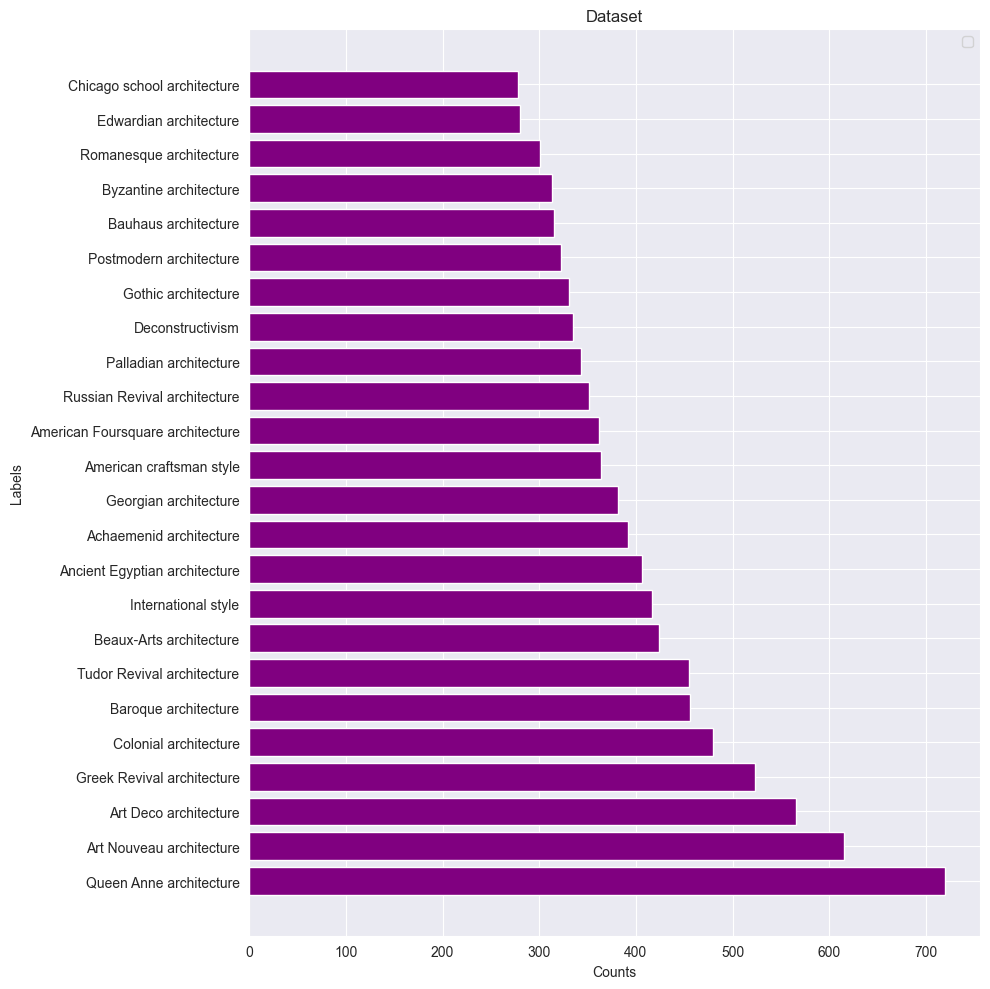

In [31]:
general_dataset_labels = data['label'].value_counts()
unique_labels = general_dataset_labels.index.tolist()
unique_labels.sort(key=lambda label: general_dataset_labels[label], reverse=True)

plt.figure(figsize=(10, 10))
plt.barh(range(len(unique_labels)), [general_dataset_labels.get(label, 0) for label in unique_labels], color='purple')
plt.title('Dataset')

plt.xlabel('Counts')
plt.ylabel('Labels')
plt.yticks(range(len(unique_labels)), unique_labels)
plt.tight_layout()
plt.show()


# Image Data Generators

In [32]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
IMG_CHANNELS = 3

abs_file_names = []

train_datagen = ImageDataGenerator(rescale=1.0 / 255.0,
                                   zoom_range=0.3,
                                   rotation_range=20,
                                   horizontal_flip=True,
                                   shear_range=0.1,
                                   fill_mode='nearest',
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   brightness_range=[0.4,1.5],
                                   )

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_dataframe(
    train_dataset,
    directory=None,
    target_size=IMG_SIZE,
    x_col='image_name',
    y_col='label',
    batch_size=BATCH_SIZE,
)

validation_generator = test_datagen.flow_from_dataframe(
    validation_dataset,
    directory=None,
    target_size=IMG_SIZE,
    x_col='image_name',
    y_col='label',
    batch_size=BATCH_SIZE,
    shuffle=False
)
test_generator = test_datagen.flow_from_dataframe(
    test_dataset,
    directory=None,
    target_size=IMG_SIZE,
    x_col='image_name',
    y_col='label',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 6811 validated image filenames belonging to 24 classes.
Found 2336 validated image filenames belonging to 24 classes.
Found 583 validated image filenames belonging to 24 classes.


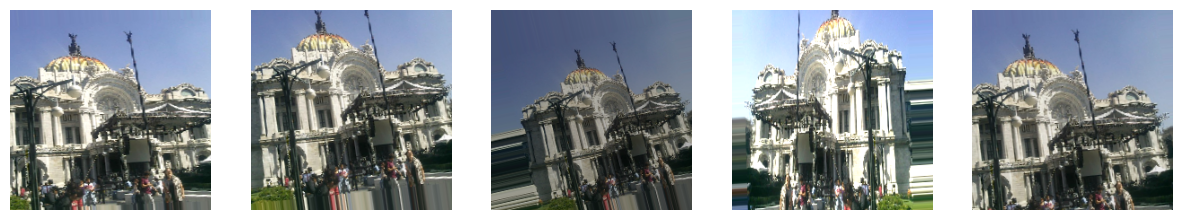

In [33]:
augmented_images = [train_generator[0][0][0] for _ in range(5)]  
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, image in enumerate(augmented_images):
    axes[i].imshow(image)
    axes[i].axis('off')
plt.show()

In [34]:
class_labels = np.unique(train_generator.classes)
class_weights = compute_class_weight('balanced', classes=class_labels, y=train_generator.classes)
class_weight_dict = dict(zip(class_labels, class_weights))
class_weight_dict

{0: 1.03573600973236,
 1: 1.1217061923583662,
 2: 1.1129084967320262,
 3: 0.9992664319248826,
 4: 0.716645622895623,
 5: 0.6599806201550388,
 6: 0.8896290491118077,
 7: 1.2841251885369533,
 8: 0.9555274971941639,
 9: 1.2958523592085236,
 10: 1.4553418803418803,
 11: 0.8446180555555556,
 12: 1.2076241134751773,
 13: 1.4479166666666667,
 14: 1.0628901373283395,
 15: 1.2232399425287357,
 16: 0.7753870673952641,
 17: 0.9718892694063926,
 18: 1.1824652777777778,
 19: 1.2612962962962964,
 20: 0.5630787037037037,
 21: 1.3449842022116905,
 22: 1.1536246612466126,
 23: 0.8924266247379455}

# Creating Model

In [35]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, restore_best_weights=True)

In [36]:
preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input

In [37]:
def arc_model(image_shape=IMG_SIZE):
    input_shape = image_shape + (3,)
    base_model = tf.keras.applications.EfficientNetV2B0(input_shape=input_shape,
                                                        include_top=False,
                                                        weights='imagenet')
    base_model.trainable = False
    inputs = tf.keras.Input(shape=input_shape)
    x = preprocess_input(inputs)

    x = base_model(x, training=False)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.8)(x)
    x = tf.keras.layers.Dense(1024,activation='relu')(x)
    # x = tf.keras.layers.Dropout(0.8)(x)
    x = tf.keras.layers.Dense(1024,activation='relu')(x)
    # x = tf.keras.layers.Dropout(0.8)(x)
    x = tf.keras.layers.Dense(512,activation='relu')(x)
    # x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    # x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(24, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)

    return model

In [38]:
arch_model = arc_model(IMG_SIZE)
# Print a summary for each layer
print(arch_model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 24)             │         6,168 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,942,952 (34.11 MB)

 Trainable params: 3,023,640 (11.53 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

None


In [39]:
arch_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.F1Score, "precision"])

In [41]:
res = arch_model.fit(
    train_generator,
    # steps_per_epoch=176, # 22,564 images = batch_size * steps
    epochs=10,
    verbose=1,
    validation_data = validation_generator, # 2,513 images = batch_size * steps
    callbacks=[learning_rate_reduction, early_stopping],

)

Epoch 1/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 930ms/step - accuracy: 0.0664 - f1_score: 0.0174 - loss: 3.1616 - precision: 0.0000e+00

C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



213/213 ━━━━━━━━━━━━━━━━━━━━ 272s 1s/step - accuracy: 0.0664 - f1_score: 0.0174 - loss: 3.1616 - precision: 0.0000e+00 - val_accuracy: 0.0741 - val_f1_score: 0.0057 - val_loss: 3.1482 - val_precision: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 206s 953ms/step - accuracy: 0.0710 - f1_score: 0.0063 - loss: 3.1577 - precision: 0.0000e+00 - val_accuracy: 0.0741 - val_f1_score: 0.0057 - val_loss: 3.1472 - val_precision: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 808ms/step - accuracy: 0.0710 - f1_score: 0.0076 - loss: 3.1531 - precision: 0.0000e+00
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
213/213 ━━━━━━━━━━━━━━━━━━━━ 209s 967ms/step - accuracy: 0.0710 - f1_score: 0.0076 - loss: 3.1531 - precision: 0.0000e+00 - val_accuracy: 0.0741 - val_f1_score: 0.0057 - val_loss: 3.1471 - val_precision: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 207s 958ms/step - accuracy: 

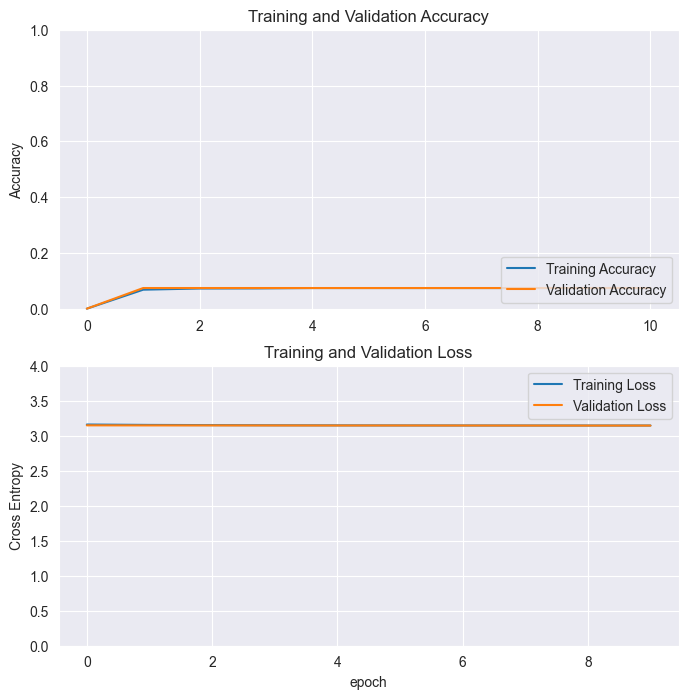

In [42]:
    # validation_steps=20)
acc = [0.] + res.history['accuracy']
val_acc = [0.] + res.history['val_accuracy']

loss = res.history['loss']
val_loss = res.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
loss, accuracy = arch_model.evaluate(test_generator, batch_size=BATCH_SIZE, verbose=0)
print('Test Loss:', loss, 'Test Accuracy:', accuracy)

C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
OSError: image file is truncated (11 bytes not processed)
Traceback (most recent call last):

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\tensorflow\python\ops\script_ops.py", line 270, in __call__
    ret = func(*args)

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py", line 250, in _get_iterator
    for i, batch in enumerate(gen_fn()):

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py", line 244, in generator_fn
    yield self.py_dataset[i]

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\keras\src\legacy\preprocessing\image.py", line 68, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\keras\src\legacy\preprocessing\image.py", line 313, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\keras\src\utils\image_utils.py", line 292, in load_img
    img = img.resize(width_height_tuple, resample)

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\PIL\Image.py", line 2185, in resize
    self.load()

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\PIL\ImageFile.py", line 288, in load
    raise OSError(msg)

OSError: image file is truncated (11 bytes not processed)


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_68569]

In [28]:
prediction = arch_model.predict(test_generator, batch_size=BATCH_SIZE, verbose=0)
pr = np.argmax(prediction, axis=1)
print(classification_report(test_generator.labels, pr, target_names=unique_labels))

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} OSError: image file is truncated (11 bytes not processed)
Traceback (most recent call last):

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\tensorflow\python\ops\script_ops.py", line 270, in __call__
    ret = func(*args)

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py", line 250, in _get_iterator
    for i, batch in enumerate(gen_fn()):

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py", line 244, in generator_fn
    yield self.py_dataset[i]

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\keras\src\legacy\preprocessing\image.py", line 68, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\keras\src\legacy\preprocessing\image.py", line 313, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\keras\src\utils\image_utils.py", line 292, in load_img
    img = img.resize(width_height_tuple, resample)

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\PIL\Image.py", line 2185, in resize
    self.load()

  File "C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\PIL\ImageFile.py", line 288, in load
    raise OSError(msg)

OSError: image file is truncated (11 bytes not processed)


	 [[{{node PyFunc}}]] [Op:IteratorGetNext] name: 

In [29]:
# conf_matrix = confusion_matrix(test_generator.labels, pr)
# sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=unique_labels, yticklabels=unique_labels)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

In [31]:
for epoch, history in enumerate(res.history['loss']):
    task.get_logger().report_scalar("training", "loss", history, iteration=epoch)
for epoch, history in enumerate(res.history['accuracy']):
    task.get_logger().report_scalar("training", "accuracy", history, iteration=epoch)
for epoch, history in enumerate(res.history['val_loss']):
    task.get_logger().report_scalar("validation", "loss", history, iteration=epoch)
for epoch, history in enumerate(res.history['val_accuracy']):
    task.get_logger().report_scalar("validation", "accuracy", history, iteration=epoch)


In [32]:
arch_model.save("imbalanced.h5")
task.upload_artifact("imbalanced.h5", name="imbalanced")

TypeError: F1Score.get_config() missing 1 required positional argument: 'self'